# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.85


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

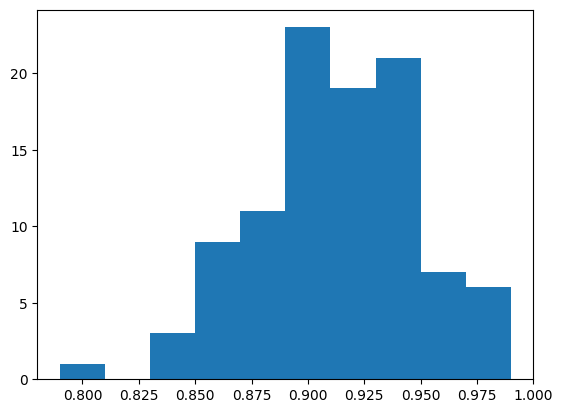

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

The main problem here is a methodological error in the process of feature selection before cross-validation, which results in what's called "data leakage". The feature selection occurs before to the cross-validation cycle. This implies that information from the whole dataset is utilized to choose the features, including data from each cross-validation split's test fold. This leaks information about the test set into the training process, which can lead to an overestimation of the model's performance.

Normally, we expect an accuracy of 50% because the targets are randomly generated and independent of the features, implying that there is no real relationship for the model to learn. However, because the feature selection is done on the entire dataset, it's finding the features that just happen to have the strongest relationship with the random targets due to chance alone. Since the same selected features are used in both the training and testing phases of each cross-validation split, the model appears to perform better than random chance.

To fix this problem, feature selection needs to be part of the cross-validation process. Each fold should have its own feature selection step, which is only applied to the training data of that fold. The test data should remain unseen and not influence which features are selected.


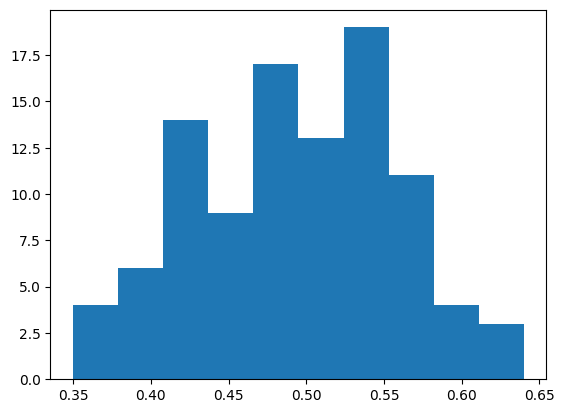

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import numpy as np
import matplotlib.pyplot as plt

# Updated FeatureSelector
class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features  # number of best features to select

    def fit(self, X, y):
        covariance = ((X - X.mean(axis=0)) * (y[:, np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
        return self

    def transform(self, X):
        return X[:, self.best_feature_ids]

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

num_features_total = 1000
num_features_best = 100
N = 100

def experiment():
    # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    # Create a pipeline that includes feature selection and the model
    pipeline = Pipeline([
        ('feature_selection', FeatureSelector(num_features_best)),
        ('model', LinearSVC())
    ])

    # Estimate accuracy using cross-validation
    # The feature selection now happens within the cross-validation loop
    return cross_val_score(pipeline, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

# Running the experiment multiple times
results = [experiment() for _ in range(100)]
plt.hist(results, bins=10)
plt.show()


## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [6]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2023-11-04 13:32:44--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv.3’

train.csv.3         100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2023-11-04 13:32:44 (4.10 MB/s) - ‘train.csv.3’ saved [60302/60302]



In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("train.csv", index_col='PassengerId')


In [8]:
param_grid = {
    'n_neighbors': range(1,13),  # testing different numbers of neighbors
    'weights': ['uniform', 'distance'],  # the weight function used in prediction
    'metric': ['euclidean', 'manhattan'],  # the distance metric to use for the tree
    'p': [1, 2, 3]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

scaler = MinMaxScaler()
def feature_selection_and_preprocessing(dataset):
    features = dataset[["Fare", "Parch", "Age", "Sex", "Pclass"]].copy()
    features["Age"].fillna(features["Age"].mean(), inplace=True)
    features = pd.get_dummies(features, columns=["Sex", "Pclass"], drop_first=True)
    scaled_features = scaler.fit_transform(features)
    return scaled_features




In [9]:
#Validation Code
data_train = data.iloc[:-100] #Using the same train and test as it was in the task 3
data_test = data.iloc[-100:]
X_train = feature_selection_and_preprocessing(data_train.drop('Survived', axis=1))
y_train = data_train['Survived']

grid_search.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 13), 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [10]:
print("Best parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

X_test = feature_selection_and_preprocessing(data_test.drop('Survived', axis=1))
y_test = data_test['Survived']

test_predictions = best_knn.predict(X_test)
print("Test accuracy with the best KNN model:", accuracy_score(y_test, test_predictions))


Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Test accuracy with the best KNN model: 0.83


We changed the future selection and preprocessing function and got the best acc as 83%. Also the same validation code is used as it was in the Task3 of homework 1

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def feature_selection_and_preprocessing(dataset):
    features = dataset[["Fare", "Parch", "Age", "Sex", "Pclass"]].copy()
    features["Age"].fillna(features["Age"].mean(), inplace=True)
    features = pd.get_dummies(features, columns=["Sex", "Pclass"], drop_first=True)
    features["Fare"] /= features["Fare"].mean()
    features["Age"] /= features["Age"].mean()

    return features

param_grid = {
    'n_neighbors': range(9,10),  # testing different numbers of neighbors
    'weights': ['uniform', 'distance'],  # the weight function used in prediction
    'metric': ['euclidean', 'manhattan'],  # the distance metric to use for the tree
    'p': [1, 2, 3]  # power parameter for the Minkowski metric
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]


X_train = feature_selection_and_preprocessing(data_train.drop('Survived', axis=1))
y_train = data_train['Survived']
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

X_test = feature_selection_and_preprocessing(data_test.drop('Survived', axis=1))
y_test = data_test['Survived']

test_predictions = best_knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, test_predictions))


Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Test accuracy: 0.85


For n_neighbours = 9 in the Task 3 we achieved the highest accuracy and here we used the same preprocessing function and explicitly mentioned the NN as 9 and got the accuracy as 85%